In [1]:
from quadratic_monte_carlo import *
from state import *
import corner

In [2]:
def agreement_test(mu1, mu2, sig1, sig2):
    dmu = np.abs(mu1-mu2)
    return dmu/(2*np.sqrt(sig1*sig1+sig2*sig2))

Example 1: The Harmonic Oscillator

In [3]:
# e.g.1: harmonic oscillator potential

# define a log probability function
def harmonic_lnp(params):
    n = len(params)
    v = 0
    for j in range(n):
        v += params[j] * params[j]
    return -(v / 0.01) 

In [4]:
# define a QMCState that is a 6-dimensional harmonic oscillator
harmonic_state = QMCState(6, harmonic_lnp, np.zeros(6)) # setup the QMCState

# setup simulation parameters
ndim = 6  # number of parameters in the model
nwalkers = 20  # number of MCMC walkers
nburn = 10000  # "burn-in" period to let chains stabilize
nsteps = 100000  # number of MCMC steps to take

# setup starting guesses randomly
sg = np.random.random((nwalkers, ndim))
starting_guesses = set_up_starting_guesses(harmonic_state, sg)

# setup sampler and run mcmc
sampler = QMCSampler(nwalkers, harmonic_state, gaussian=True)
sampler.run_qmc(starting_guesses, nsteps)

# get the trace after the chain stablizes
qmc_harmonic_trace = sampler.chain[nburn:, :]

In [5]:
print(np.shape(qmc_harmonic_trace))

(90000, 20)


In [6]:
# calculate the average potential energy and the associated error
v_arr = []

for i in range(90000):
    for j in range(20):
        v = -qmc_harmonic_trace[i, j].lnL*0.01
        v_arr.append(v)
avg_v = np.mean(v_arr)
err = np.std(v_arr)/np.sqrt(90000*20)
print(f'the average energy is: {avg_v} +- {err}')

the average energy is: 0.03007058232365213 +- 1.2946318455655261e-05


In [7]:
# perform agreement test w/ c++ code
mu_harmonic = 0.03003602
sig_harmonic = 0.00001169 
print(f'the agreement test value is {agreement_test(avg_v, mu_harmonic, err, sig_harmonic)}')

the agreement test value is 0.9907137233891617


Example 2: The Ring Potential

In [8]:
# e.g.2: ring potential

# define a 6-dimensional ring potential function
def ring_lnp(params):
    rho = np.sqrt(params[0] ** 2 + params[1] ** 2)
    v = pow(12 * (rho - 1), 12)
    i = 2
    while i < 6:
        v += pow(12 * params[i], 12)
        i += 1
    v -= 0.01 * params[0]
    return -v / 0.01

In [9]:
# define a QMCState that is a 6-dimensional ring potential
ring_state = QMCState(6, ring_lnp, np.zeros(6)) # setup the QMCState

# setup simulation parameters
ndim = 6  # number of parameters in the model
nwalkers = 20  # number of MCMC walkers
nburn = 10000  # "burn-in" period to let chains stabilize
nsteps = 100000  # number of MCMC steps to take

# setup starting guesses randomly
sg = np.random.random((nwalkers, ndim))
starting_guesses = set_up_starting_guesses(ring_state, sg)

# setup sampler and run mcmc
sampler = QMCSampler(nwalkers, ring_state, gaussian=True)
sampler.run_qmc(starting_guesses, nsteps)

# get the trace after the chain stablizes
qmc_ring_trace = sampler.chain[nburn:, :]

In [10]:
# calculate the average potential energy and the associated error
v_arr = []

for i in range(90000):
    for j in range(20):
        v = -qmc_ring_trace[i, j].lnL*0.01
        v_arr.append(v)
avg_v = np.mean(v_arr)
err = np.std(v_arr)/np.sqrt(90000*20)
print(f'the average energy is: {avg_v} +- {err}')

the average energy is: -0.00039601365840831123 +- 6.528410604842213e-06


In [11]:
# perform agreement test w/ c++ code
mu_ring = -0.00030795
sig_ring = 0.00004486 
print(f'the agreement test value is {agreement_test(avg_v, mu_ring, err, sig_ring)}')

the agreement test value is 0.9713072151155046


Example 3: The Rosenbrock Function

In [12]:
# e.g.2 rosenbrock function

# define a 2-d rodenbrock function
def rosenbrock_lnp(params):
    x1, x2 = params
    lnL = ((-100 * pow((x2 - pow(x1, 2)), 2)) - pow((1 - x1), 2)) / 20
    return lnL


In [33]:
# define a QMCState that is a 2-dimensional rosenbrock function
rosenbrock_state = QMCState(2, rosenbrock_lnp, np.zeros(2)) # setup the QMCState

# setup simulation parameters
ndim = 2  # number of parameters in the model
nwalkers = 5  # number of MCMC walkers
nburn = 10000  # "burn-in" period to let chains stabilize
nsteps = 100000  # number of MCMC steps to take

# setup starting guesses randomly
sg = np.random.random((nwalkers, ndim))
starting_guesses = set_up_starting_guesses(rosenbrock_state, sg)

# setup sampler and run mcmc
sampler = QMCSampler(nwalkers, rosenbrock_state, gaussian=True)
sampler.run_qmc(starting_guesses, nsteps)

# get the trace after the chain stablizes
qmc_rosenbrock_trace = sampler.chain[nburn:, :]

In [34]:
# calculate the average potential energy and the associated error
v_arr = []

for i in range(90000):
    for j in range(5):
        v = qmc_rosenbrock_trace[i, j].lnL
        v_arr.append(v)
avg_v = np.mean(v_arr)
err = np.std(v_arr)/np.sqrt(90000*5)
print(f'the average energy is: {avg_v} +- {err}')

the average energy is: -0.9766129819506443 +- 0.001453867992882392


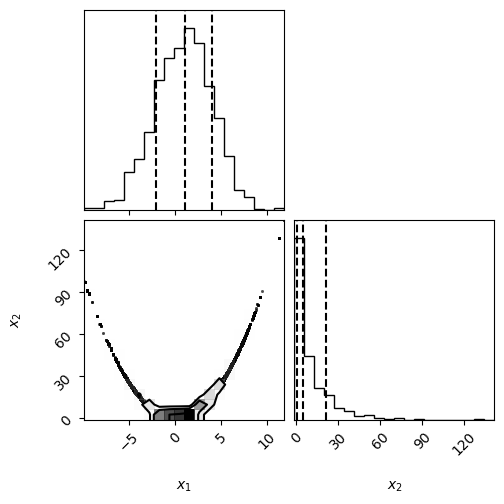

In [35]:
# visulize the sampled density
qmc_chain = []
for i in range(90000):
    for j in range(5):
        x1, x2 = qmc_rosenbrock_trace[i, j].p
        qmc_chain.append([x1, x2])
fig = corner.corner(
    np.array(qmc_chain), quantiles=[0.16, 0.5, 0.84],
    labels=[
        r"$x_{1}$",
        r"$x_{2}$",
    ]
)

In [29]:
# compare with rosenbrock density sampled with emcee
import emcee
emcee_trace = []

for i in range(1):
    # Here we'll set up the computation. emcee combines multiple "walkers",
    # each of which is its own MCMC chain. The number of trace results will
    # be nwalkers * nsteps

    ndim = 2  # number of parameters in the model
    nwalkers = 5  # number of MCMC walkers
    nburn = 10000 # "burn-in" period to let chains stabilize
    nsteps = 100000  # number of MCMC steps to take

    # set theta near the maximum likelihood, with
    starting_guesses = np.random.random((nwalkers, ndim))

    # Here's the function call where all the work happens:
    # we'll time it using IPython's %time magic

    sampler = emcee.EnsembleSampler(nwalkers, ndim, rosenbrock_lnp)
    sampler.run_mcmc(starting_guesses, nsteps)
    emcee_trace.append(sampler.chain[:, nburn:, :].reshape(-1, ndim))

emcee_trace = np.array(emcee_trace)

In [30]:
print(np.shape(emcee_trace))

(1, 450000, 2)


In [31]:
v_arr = []
for i in range(450000):
    params = emcee_trace[0, i, :]
    v_arr.append(rosenbrock_lnp(params))
print(np.mean(v_arr))

-0.9471748921889068


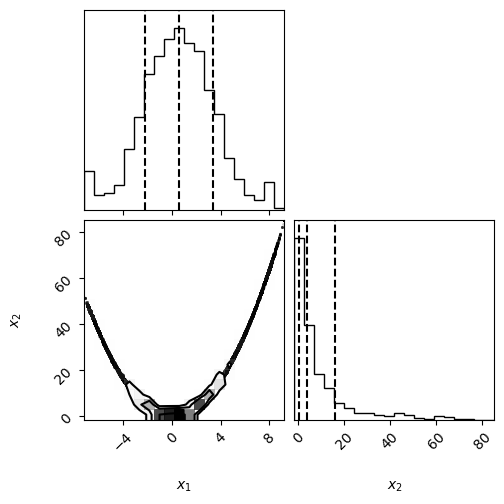

In [32]:
fig = corner.corner(
    sampler.get_chain(flat=True), quantiles=[0.16, 0.5, 0.84],
    labels=[
        r"$x_{1}$",
        r"$x_{2}$",
    ]
)